<a href="https://colab.research.google.com/github/Eduzc07/machinelearning/blob/master/3_Cybersecurity/FraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Detection

As first step we have to install de kaggle API.

In [0]:
!pip install -q kaggle

Then, we are going to save the API key in order to use the API.

In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"  # NOTE: This is different from the Medium post!
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In case it does not work, please "reset all runtimes", not restart.

Source: ["404 - Not Found" when downloading dataset from Google Colab](https://github.com/Kaggle/kaggle-api/issues/110)

In [3]:
!kaggle datasets list

ref                                                       title                                              size  lastUpdated          downloadCount  
--------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
dgomonov/new-york-city-airbnb-open-data                   New York City Airbnb Open Data                      2MB  2019-08-12 16:24:45          10008  
lakshyaag/india-trade-data                                India - Trade Data                                  1MB  2019-08-16 16:13:58           5832  
therohk/ireland-historical-news                           The Irish Times - Waxy-Wany News                   47MB  2019-08-24 15:36:54            825  
bradklassen/pga-tour-20102018-data                        PGA Tour Golf Data                                 94MB  2019-08-30 00:09:59           5170  
r3w0p4/bournemouth-venues                                 Venues in Bournemouth         

Now, we are going to download the data from Kaggle.
[IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection)

In [4]:
!kaggle competitions download -c ieee-fraud-detection

train_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


The Data has been downloaded in .zip file, then we have to unzip them.

In [5]:
!yes | unzip train_identity.csv.zip
!yes | unzip train_transaction.csv.zip
!yes | unzip test_identity.csv.zip
!yes | unzip test_transaction.csv.zip

Archive:  train_identity.csv.zip
replace train_identity.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: train_identity.csv      
Archive:  train_transaction.csv.zip
replace train_transaction.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: train_transaction.csv   
Archive:  test_identity.csv.zip
replace test_identity.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: test_identity.csv       
Archive:  test_transaction.csv.zip
replace test_transaction.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: test_transaction.csv    


Run all the required imports.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# SciKit-Learn
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import csv

Read the data using panda.

In [74]:
%%time
train_id = pd.read_csv('train_identity.csv')
train_trn = pd.read_csv('train_transaction.csv')
test_id = pd.read_csv('test_identity.csv')
test_trn = pd.read_csv('test_transaction.csv')

print('train transaction size:', len(train_trn))
print('test transaction size:', len(test_trn))

train transaction size: 590540
test transaction size: 506691
CPU times: user 50.8 s, sys: 5.51 s, total: 56.3 s
Wall time: 56.3 s


In [75]:
train_trn_new = pd.DataFrame(train_trn, columns=train_trn.isnull().sum().sort_values()[:196].index)
train_trn_new = train_trn_new.drop(columns=['TransactionID', 'TransactionDT', 'card6', 'card4', 'P_emaildomain'])
train_trn_new_label = train_trn_new.isFraud
train_trn_new = train_trn_new.drop(columns=['isFraud'])
train_trn_new.head()

,C14,C13,C12,C11,C10,C9,C8,C7,C6,C5,C4,C3,C2,C1,TransactionAmt,ProductCD,card1,V309,V306,V307,V299,V321,V320,V319,V318,V316,V312,V311,V305,V308,V310,V304,V317,V302,V303,V298,V297,V295,V294,V292,...,V71,V72,V74,V64,V73,D15,V94,V75,V76,V77,V78,V79,V80,V81,V83,V82,V86,V87,V88,V89,V90,V91,V92,V93,V84,V85,D4,V40,V41,V38,V52,V39,V37,V49,V48,V51,V46,V45,V47,V43
0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,68.5,W,13926,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,29.0,W,2755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
2,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,59.0,W,4663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,315.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
3,1.0,25.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,5.0,2.0,50.0,W,18132,0.0,50.0,1758.0,0.0,0.0,0.0,0.0,790.0,50.0,135.0,0.0,1.0,925.0,354.0,0.0,1404.0,0.0,0.0,0.0,0.0,24.0,38.0,1.0,...,0.0,0.0,0.0,0.0,0.0,111.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
4,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,50.0,H,4497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Preparing test data.

In [76]:
test_trn_new = pd.DataFrame(test_trn, columns=train_trn.isnull().sum().sort_values()[:196].index)
test_trn_new = test_trn_new.drop(columns=['isFraud', 'TransactionID', 'TransactionDT', 'card6', 'card4', 'P_emaildomain'])
test_trn_new.head()

,C14,C13,C12,C11,C10,C9,C8,C7,C6,C5,C4,C3,C2,C1,TransactionAmt,ProductCD,card1,V309,V306,V307,V299,V321,V320,V319,V318,V316,V312,V311,V305,V308,V310,V304,V317,V302,V303,V298,V297,V295,V294,V292,...,V71,V72,V74,V64,V73,D15,V94,V75,V76,V77,V78,V79,V80,V81,V83,V82,V86,V87,V88,V89,V90,V91,V92,V93,V84,V85,D4,V40,V41,V38,V52,V39,V37,V49,V48,V51,V46,V45,V47,V43
0,6.0,115.0,1.0,5.0,0.0,6.0,0.0,0.0,4.0,3.0,0.0,0.0,6.0,6.0,31.95,W,10409,0.000000,0.000000,47.950001,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.000000,47.950001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,409.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,398.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
1,2.0,12.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,49.00,W,4272,0.000000,0.000000,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,77.000000,0.000000,1.0,77.000000,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,634.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,634.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
2,2.0,22.0,0.0,2.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,2.0,2.0,171.00,W,4476,0.000000,0.000000,1321.000000,0.0,0.0,263.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.000000,1058.000000,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,97.0,0.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
3,4.0,7.0,0.0,2.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,5.0,284.95,W,10989,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,242.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,242.0,0.0,1.0,2.0,0.0,0.0,2.0,1.0,1.0,0.0,2.0,2.0,2.0,0.0
4,6.0,14.0,0.0,6.0,0.0,5.0,0.0,0.0,5.0,2.0,0.0,0.0,6.0,6.0,67.95,W,18018,67.949997,67.949997,183.850006,0.0,0.0,0.0,0.0,0.0,0.0,67.949997,67.949997,1.0,67.949997,183.850006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,22.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,22.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0


## Visualize the Dataset

Credits to [Roy](https://github.com/RoyMachineLearning/IEEE-CIS-Fraud-Detection).

### Ploting amount of Fraud Transactions

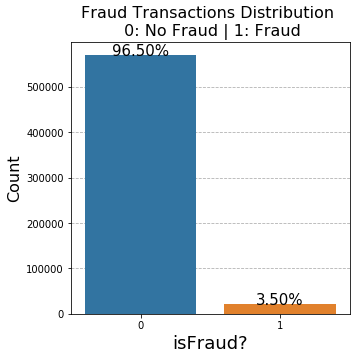

In [77]:
total = len(train_trn_new)

fig = plt.figure(figsize=(5,5))
fig.patch.set_facecolor('xkcd:white')

plot_tr = sns.countplot(x='isFraud', data=train_trn)
plt.title('Fraud Transactions Distribution \n 0: No Fraud | 1: Fraud', fontsize=16)
plt.xlabel('isFraud?', fontsize=18)
plt.ylabel('Count', fontsize=16)

for p in plot_tr.patches:
    height = p.get_height()
    plot_tr.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 
#plt.grid()
ax = plt.gca()
ax.grid(which='major', axis='y', linestyle='--')
ax.yaxis.grid(True)
ax.set_axisbelow(True)
plt.show()

### Ploting Transaction Amount Values Distribution

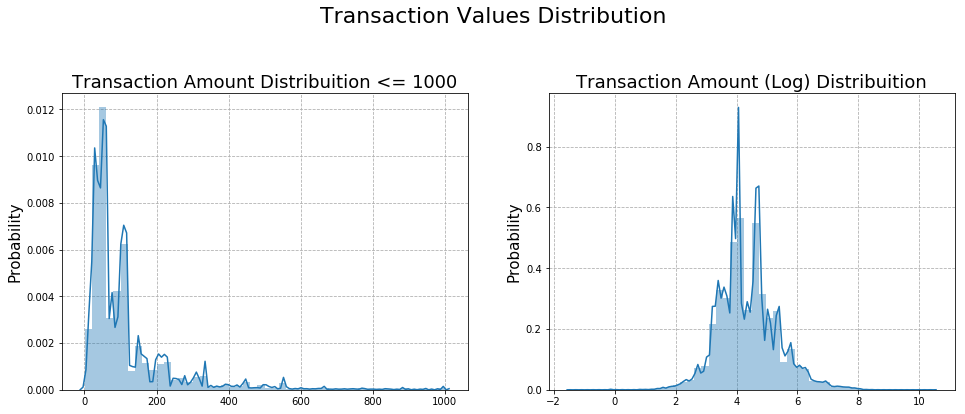

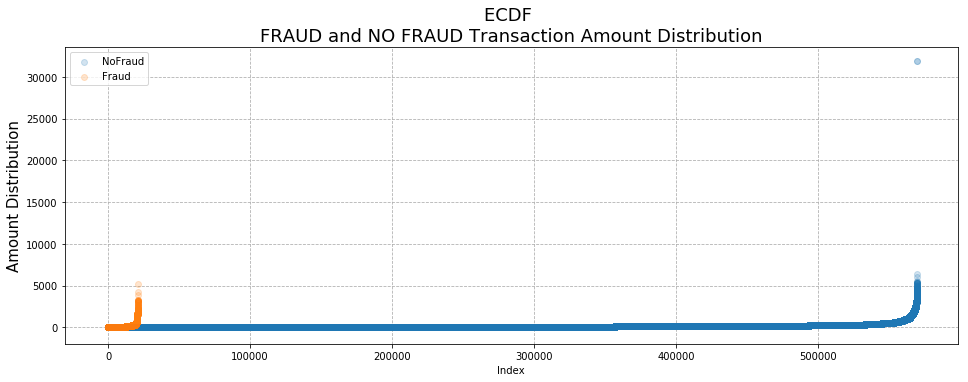

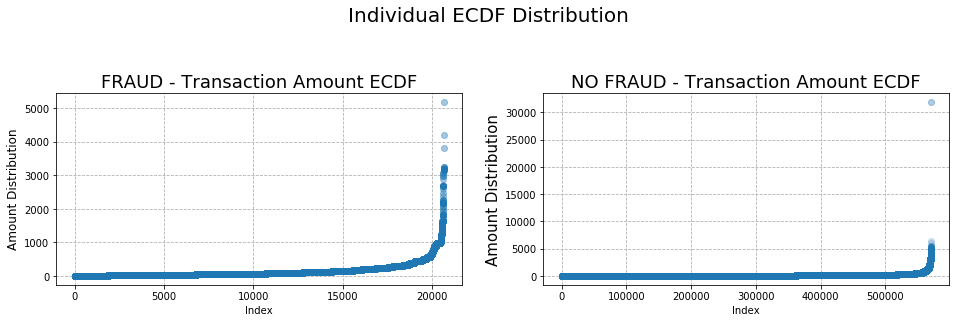

In [78]:
fig = plt.figure(figsize=(16, 12))
fig.patch.set_facecolor('xkcd:white')

# Plot 1
plt.suptitle('Transaction Values Distribution', fontsize=22)
plt.subplot(221)
sub_plot_1 = sns.distplot(train_trn_new[train_trn_new['TransactionAmt'] <= 1000]['TransactionAmt'])
sub_plot_1.set_title("Transaction Amount Distribuition <= 1000", fontsize=18)
sub_plot_1.set_xlabel("")
sub_plot_1.set_ylabel("Probability", fontsize=15)

ax = plt.gca()
ax.grid(which='major', axis='both', linestyle='--')
ax.set_axisbelow(True)

plt.subplot(222)
sub_plot_2 = sns.distplot(np.log(train_trn_new['TransactionAmt']))
sub_plot_2.set_title("Transaction Amount (Log) Distribuition", fontsize=18)
sub_plot_2.set_xlabel("")
sub_plot_2.set_ylabel("Probability", fontsize=15)

ax = plt.gca()
ax.grid(which='major', axis='both', linestyle='--')
ax.set_axisbelow(True)

# Plot 2
fig = plt.figure(figsize=(16, 12))
fig.patch.set_facecolor('xkcd:white')

plt.subplot(212)
sub_plot_3 = plt.scatter(range(train_trn[train_trn['isFraud'] == 0].shape[0]),
                 np.sort(train_trn[train_trn['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
sub_plot_3 = plt.scatter(range(train_trn[train_trn['isFraud'] == 1].shape[0]),
                 np.sort(train_trn[train_trn['isFraud'] == 1]['TransactionAmt'].values), 
                 label='Fraud', alpha=.2)
sub_plot_3= plt.title("ECDF \nFRAUD and NO FRAUD Transaction Amount Distribution", fontsize=18)
sub_plot_3 = plt.xlabel("Index")
sub_plot_3 = plt.ylabel("Amount Distribution", fontsize=15)
sub_plot_3 = plt.legend()

ax = plt.gca()
ax.grid(which='major', axis='both', linestyle='--')
ax.set_axisbelow(True)

# Plot 3
fig = plt.figure(figsize=(16, 12))
fig.patch.set_facecolor('xkcd:white')

plt.subplot(321)
sub_plot_4 = plt.scatter(range(train_trn[train_trn['isFraud'] == 1].shape[0]), 
                 np.sort(train_trn[train_trn['isFraud'] == 1]['TransactionAmt'].values), 
                label='isFraud', alpha=.4)
plt.title("FRAUD - Transaction Amount ECDF", fontsize=18)
plt.xlabel("Index")
plt.ylabel("Amount Distribution", fontsize=12)

ax = plt.gca()
ax.grid(which='major', axis='both', linestyle='--')
ax.set_axisbelow(True)

plt.subplot(322)
sub_plot_5 = plt.scatter(range(train_trn[train_trn['isFraud'] == 0].shape[0]),
                 np.sort(train_trn[train_trn['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
sub_plot_5 = plt.title("NO FRAUD - Transaction Amount ECDF", fontsize=18)
sub_plot_5 = plt.xlabel("Index")
sub_plot_5 = plt.ylabel("Amount Distribution", fontsize=15)

plt.suptitle('Individual ECDF Distribution', fontsize=20)
ax = plt.gca()
ax.grid(which='major', axis='both', linestyle='--')
ax.set_axisbelow(True)

plt.show()


Use [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) to change text to int.

In [79]:
labelencoder = LabelEncoder()
test_trn_new['ProductCD'] = labelencoder.fit_transform(test_trn_new['ProductCD'])
test_trn_new.ProductCD[:5]

0    4
1    4
2    4
3    4
4    4
Name: ProductCD, dtype: int64

In [80]:
train_trn_new['ProductCD'] = labelencoder.fit_transform(train_trn_new['ProductCD'])
train_trn_new.ProductCD[:5]

0    4
1    4
2    4
3    4
4    1
Name: ProductCD, dtype: int64

Fill NA/NaN values using -9999.

In [0]:
train_trn_new = train_trn_new.fillna(-9999)
test_trn_new = test_trn_new.fillna(-9999)

Split data and train a Logistic Regression Model.

In [82]:
x_train, x_test, y_train, y_test = train_test_split(train_trn_new, train_trn_new_label, test_size=0.2)

#from SciKit-Learn
lr = LogisticRegression(C=0.09, solver='lbfgs', class_weight='balanced')
lr = lr.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Get Score from trained model.

In [84]:
y_predict = lr.predict(x_test)
score = accuracy_score(y_predict, y_test)
print('Score using Logistic Regression: {:.2f}%'.format(score*100))

Score using Logistic Regression: 71.59%


In [85]:
y_sub_predict = lr.predict_proba(test_trn_new)

csv_data = [['TransactionID', 'isFraud']]

fraud_dict = { 'fraud': 0, 'not_fraud': 0 }
for i in range(0, len(y_sub_predict)):
  csv_data.append([test_trn['TransactionID'][i], y_sub_predict[i][0]])
  if y_sub_predict[i][0] >= 0.5:
    fraud_dict['fraud'] += 1
  else:
    fraud_dict['not_fraud'] += 1
print(fraud_dict)

{'fraud': 394430, 'not_fraud': 112261}


Save file to upload to Kaggle

In [0]:
with open('submission.csv', 'w') as csv_file:
  writer = csv.writer(csv_file)
  writer.writerows(csv_data)

csv_file.close()

Upload submit directly to kaggle.

In [87]:
!kaggle competitions submit -c ieee-fraud-detection -f submission.csv -m "Logistic Model test"

100% 13.5M/13.5M [00:01<00:00, 7.78MB/s]
Successfully submitted to IEEE-CIS Fraud Detection

Used Sources:

* [RoyMachineLearning](https://github.com/RoyMachineLearning/IEEE-CIS-Fraud-Detection)

* [ThiagoBfim](https://github.com/ThiagoBfim/fraud-detection)

* [FlorianWoelki](https://github.com/FlorianWoelki/fraud_detection)
